In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/NER_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/NER_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/NER_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

# Path to your GloVe pre-trained embeddings file
glove_file_path = 'glove.6B.300d.txt'

# Load GloVe embeddings
model = load_glove_model(glove_file_path)

Loading Glove Model
400000 words loaded!


In [4]:
word_embedding = model.get('hello')
print(word_embedding)

[-3.3712e-01 -2.1691e-01 -6.6365e-03 -4.1625e-01 -1.2555e+00 -2.8466e-02
 -7.2195e-01 -5.2887e-01  7.2085e-03  3.1997e-01  2.9425e-02 -1.3236e-02
  4.3511e-01  2.5716e-01  3.8995e-01 -1.1968e-01  1.5035e-01  4.4762e-01
  2.8407e-01  4.9339e-01  6.2826e-01  2.2888e-01 -4.0385e-01  2.7364e-02
  7.3679e-03  1.3995e-01  2.3346e-01  6.8122e-02  4.8422e-01 -1.9578e-02
 -5.4751e-01 -5.4983e-01 -3.4091e-02  8.0017e-03 -4.3065e-01 -1.8969e-02
 -8.5670e-02 -8.1123e-01 -2.1080e-01  3.7784e-01 -3.5046e-01  1.3684e-01
 -5.5661e-01  1.6835e-01 -2.2952e-01 -1.6184e-01  6.7345e-01 -4.6597e-01
 -3.1834e-02 -2.6037e-01 -1.7797e-01  1.9436e-02  1.0727e-01  6.6534e-01
 -3.4836e-01  4.7833e-02  1.6440e-01  1.4088e-01  1.9204e-01 -3.5009e-01
  2.6236e-01  1.7626e-01 -3.1367e-01  1.1709e-01  2.0378e-01  6.1775e-01
  4.9075e-01 -7.5210e-02 -1.1815e-01  1.8685e-01  4.0679e-01  2.8319e-01
 -1.6290e-01  3.8388e-02  4.3794e-01  8.8224e-02  5.9046e-01 -5.3515e-02
  3.8819e-02  1.8202e-01 -2.7599e-01  3.9474e-01 -2

In [5]:

def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
            # Check if word exists in the model's vocabulary
            if word in model:
                embedding.append(model[word])
            else:
                # If word not found, use zero vector
                embedding.append([0] * model["hello"].size)
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 70  # maximum length of word in a text
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * model["hello"].size] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    # Filter out None values
    padded_embeddings = [embedding for embedding in padded_embeddings if embedding is not None]

    # Convert to tensor
    input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_48207/601243325.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings, dtype=torch.float32)


In [7]:
x_train.size()

torch.Size([8019, 70, 300])

In [8]:
# unique_labels = set()
# for example in train_data.values():
#     unique_labels.update(example['labels'])
# for example in test_data.values():
#     unique_labels.update(example['labels'])
# for example in val_data.values():
#     unique_labels.update(example['labels'])
# unique_labels.remove('O')
# label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
# label_to_index['O'] = max(label_to_index.values()) +1
# print((label_to_index))

In [9]:
def convert_labels_to_fixed_length(labels, max_length):
    label_to_index = {'I_WITNESS': 0, 'B_JUDGE': 1, 'I_CASE_NUMBER': 2, 'B_CASE_NUMBER': 3, 'I_PROVISION': 4, 'B_STATUTE': 5, 'I_DATE': 6, 'I_STATUTE': 7, 'B_WITNESS': 8, 'B_DATE': 9, 'I_RESPONDENT': 10, 'B_PRECEDENT': 11, 'B_GPE': 12, 'I_ORG': 13, 'I_PETITIONER': 14, 'B_PROVISION': 15, 'B_ORG': 16, 'I_JUDGE': 17, 'I_OTHER_PERSON': 18, 'B_COURT': 19, 'B_PETITIONER': 20, 'B_RESPONDENT': 21, 'I_PRECEDENT': 22, 'I_COURT': 23, 'I_GPE': 24, 'B_OTHER_PERSON': 25, 'O': 26, '<pad>':27}
    new_list=[]
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 27
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 70
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [10]:
y_train.size()

torch.Size([8019, 70])

In [11]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


/home/bsumit43/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 28
learning_rate = 0.001
num_epochs = 130
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_48207/1893452685.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_48207/1893452685.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_48207/1893452685.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_48207/1893452685.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/130, Train Loss: 1.1532026652305845, Val Loss: 0.8599053025245667, Val F1: 0.043639444807929, Train F1: 0.035489639742876784


  2%|▋                                          | 2/130 [00:04<05:12,  2.44s/it]

Epoch 2/130, Train Loss: 0.8070122363075377, Val Loss: 0.7484105229377747, Val F1: 0.050862201746712105, Train F1: 0.04949567439740218


  2%|▉                                          | 3/130 [00:07<05:08,  2.43s/it]

Epoch 3/130, Train Loss: 0.7132608644546025, Val Loss: 0.6693989634513855, Val F1: 0.11024823314593811, Train F1: 0.07775248467118054


  3%|█▎                                         | 4/130 [00:09<05:05,  2.42s/it]

Epoch 4/130, Train Loss: 0.6475090270950681, Val Loss: 0.6187357902526855, Val F1: 0.1272893548977392, Train F1: 0.11866983333101133


  4%|█▋                                         | 5/130 [00:12<05:05,  2.44s/it]

Epoch 5/130, Train Loss: 0.6050355273579794, Val Loss: 0.5815036296844482, Val F1: 0.14755762505442113, Train F1: 0.1357491114519619


  5%|█▉                                         | 6/130 [00:14<05:01,  2.43s/it]

Epoch 6/130, Train Loss: 0.5742685572495536, Val Loss: 0.5604903697967529, Val F1: 0.1525554307553044, Train F1: 0.14892057546124388


  5%|██▎                                        | 7/130 [00:17<04:58,  2.43s/it]

Epoch 7/130, Train Loss: 0.558103073683996, Val Loss: 0.542944073677063, Val F1: 0.16289941633926094, Train F1: 0.16020841107637887


  6%|██▋                                        | 8/130 [00:19<04:56,  2.43s/it]

Epoch 8/130, Train Loss: 0.5397253556857033, Val Loss: 0.5327025651931763, Val F1: 0.16561394521215367, Train F1: 0.1654642438654666


  7%|██▉                                        | 9/130 [00:21<04:53,  2.43s/it]

Epoch 9/130, Train Loss: 0.5294023936703092, Val Loss: 0.5232566595077515, Val F1: 0.1682928463362884, Train F1: 0.17311010774088392


  8%|███▏                                      | 10/130 [00:24<04:51,  2.43s/it]

Epoch 10/130, Train Loss: 0.5210464558904133, Val Loss: 0.5152629017829895, Val F1: 0.16646035383318392, Train F1: 0.17903716075220863


  8%|███▌                                      | 11/130 [00:26<04:48,  2.43s/it]

Epoch 11/130, Train Loss: 0.5141452456277514, Val Loss: 0.5091714262962341, Val F1: 0.18966824777542413, Train F1: 0.18619594939788373


  9%|███▉                                      | 12/130 [00:29<04:49,  2.46s/it]

Epoch 12/130, Train Loss: 0.5061013182950398, Val Loss: 0.502769947052002, Val F1: 0.17570693786578506, Train F1: 0.19518172987602175


 10%|████▏                                     | 13/130 [00:31<04:46,  2.45s/it]

Epoch 13/130, Train Loss: 0.5014671522473532, Val Loss: 0.49936458468437195, Val F1: 0.21253779011932483, Train F1: 0.1991957159884576


 11%|████▌                                     | 14/130 [00:34<04:43,  2.44s/it]

Epoch 14/130, Train Loss: 0.4944074357312823, Val Loss: 0.4955124258995056, Val F1: 0.191131344589315, Train F1: 0.20455568623773088


 12%|████▊                                     | 15/130 [00:36<04:40,  2.44s/it]

Epoch 15/130, Train Loss: 0.49682878407220993, Val Loss: 0.4945879876613617, Val F1: 0.21849392117988894, Train F1: 0.20587898412196273


 12%|█████▏                                    | 16/130 [00:38<04:37,  2.44s/it]

Epoch 16/130, Train Loss: 0.48435516300655546, Val Loss: 0.48940297961235046, Val F1: 0.195136008752564, Train F1: 0.21538872699957884


 13%|█████▍                                    | 17/130 [00:41<04:37,  2.46s/it]

Epoch 17/130, Train Loss: 0.4802888466252221, Val Loss: 0.4847179651260376, Val F1: 0.2033353122589866, Train F1: 0.21636455961920556


 14%|█████▊                                    | 18/130 [00:43<04:35,  2.46s/it]

Epoch 18/130, Train Loss: 0.47728645896154737, Val Loss: 0.4877158999443054, Val F1: 0.21735611140933986, Train F1: 0.21847799387643121


 15%|██████▏                                   | 19/130 [00:46<04:31,  2.44s/it]

Epoch 19/130, Train Loss: 0.4741497238477071, Val Loss: 0.485500693321228, Val F1: 0.1991827364811438, Train F1: 0.22382793802838824


 15%|██████▍                                   | 20/130 [00:48<04:28,  2.44s/it]

Epoch 20/130, Train Loss: 0.4707732531759474, Val Loss: 0.49672138690948486, Val F1: 0.20199390700373343, Train F1: 0.22659015787494954


 16%|██████▊                                   | 21/130 [00:51<04:24,  2.43s/it]

Epoch 21/130, Train Loss: 0.4743786861026098, Val Loss: 0.48435911536216736, Val F1: 0.2068045244765933, Train F1: 0.22172333228510213


 17%|███████                                   | 22/130 [00:53<04:22,  2.43s/it]

Epoch 22/130, Train Loss: 0.4643933782501826, Val Loss: 0.4768199026584625, Val F1: 0.21833671313628203, Train F1: 0.2288817237049394


 18%|███████▍                                  | 23/130 [00:56<04:22,  2.46s/it]

Epoch 23/130, Train Loss: 0.4603990491420504, Val Loss: 0.47814083099365234, Val F1: 0.2219840291635063, Train F1: 0.23265543455499224


 18%|███████▊                                  | 24/130 [00:58<04:19,  2.45s/it]

Epoch 24/130, Train Loss: 0.45868961252863444, Val Loss: 0.4779103398323059, Val F1: 0.21987307687518848, Train F1: 0.23399177295549983


 19%|████████                                  | 25/130 [01:01<04:16,  2.45s/it]

Epoch 25/130, Train Loss: 0.45428825654680766, Val Loss: 0.47627344727516174, Val F1: 0.20260448635670802, Train F1: 0.24032282985838468


 20%|████████▍                                 | 26/130 [01:03<04:13,  2.44s/it]

Epoch 26/130, Train Loss: 0.4521247465459127, Val Loss: 0.4966762661933899, Val F1: 0.20249403164930982, Train F1: 0.24223451312047753


 21%|████████▋                                 | 27/130 [01:05<04:10,  2.43s/it]

Epoch 27/130, Train Loss: 0.4533783793449402, Val Loss: 0.4725639820098877, Val F1: 0.2253206483084669, Train F1: 0.24312732639822943


 22%|█████████                                 | 28/130 [01:08<04:07,  2.43s/it]

Epoch 28/130, Train Loss: 0.44495648997170584, Val Loss: 0.4725150465965271, Val F1: 0.2244013197307112, Train F1: 0.24811672951849392


 22%|█████████▎                                | 29/130 [01:10<04:05,  2.43s/it]

Epoch 29/130, Train Loss: 0.4459244126365298, Val Loss: 0.47361791133880615, Val F1: 0.23818742320919745, Train F1: 0.24959431102621715


 23%|█████████▋                                | 30/130 [01:13<04:02,  2.42s/it]

Epoch 30/130, Train Loss: 0.44113621541431974, Val Loss: 0.4812602698802948, Val F1: 0.1998069452765644, Train F1: 0.25526457529282065


 24%|██████████                                | 31/130 [01:15<03:59,  2.42s/it]

Epoch 31/130, Train Loss: 0.4360683782706185, Val Loss: 0.4701153337955475, Val F1: 0.23868067300859228, Train F1: 0.25601231714453215


 25%|██████████▎                               | 32/130 [01:17<03:56,  2.41s/it]

Epoch 32/130, Train Loss: 0.4359382069300091, Val Loss: 0.47829821705818176, Val F1: 0.21118638845119164, Train F1: 0.2627750017911511


 25%|██████████▋                               | 33/130 [01:20<03:54,  2.42s/it]

Epoch 33/130, Train Loss: 0.4322744163255843, Val Loss: 0.47316816449165344, Val F1: 0.23607699273446384, Train F1: 0.2580973157249393


 26%|██████████▉                               | 34/130 [01:22<03:53,  2.44s/it]

Epoch 34/130, Train Loss: 0.42909735441207886, Val Loss: 0.47660112380981445, Val F1: 0.2570306633794474, Train F1: 0.2684822374758152


 27%|███████████▎                              | 35/130 [01:25<03:50,  2.43s/it]

Epoch 35/130, Train Loss: 0.42635872392427354, Val Loss: 0.4740895926952362, Val F1: 0.24665649312197002, Train F1: 0.26910626631300094


 28%|███████████▋                              | 36/130 [01:27<03:47,  2.42s/it]

Epoch 36/130, Train Loss: 0.4238146510389116, Val Loss: 0.47126397490501404, Val F1: 0.25111867595896276, Train F1: 0.27082514179963124


 28%|███████████▉                              | 37/130 [01:30<03:49,  2.47s/it]

Epoch 37/130, Train Loss: 0.4203730911489517, Val Loss: 0.47602441906929016, Val F1: 0.2519965237121727, Train F1: 0.2759357979679237


 29%|████████████▎                             | 38/130 [01:32<03:48,  2.48s/it]

Epoch 38/130, Train Loss: 0.4172676532041459, Val Loss: 0.47274649143218994, Val F1: 0.25335565368347895, Train F1: 0.27593459548760607


 30%|████████████▌                             | 39/130 [01:35<03:44,  2.47s/it]

Epoch 39/130, Train Loss: 0.41779771021434237, Val Loss: 0.4759056866168976, Val F1: 0.2587864816622319, Train F1: 0.2812293107281751


 31%|████████████▉                             | 40/130 [01:37<03:40,  2.45s/it]

Epoch 40/130, Train Loss: 0.43155091338687473, Val Loss: 0.49198734760284424, Val F1: 0.2459085503688289, Train F1: 0.2721491990701393


 32%|█████████████▏                            | 41/130 [01:39<03:37,  2.44s/it]

Epoch 41/130, Train Loss: 0.4151656755379268, Val Loss: 0.4764701724052429, Val F1: 0.2527871482917968, Train F1: 0.28310190422620646


 32%|█████████████▌                            | 42/130 [01:42<03:34,  2.44s/it]

Epoch 42/130, Train Loss: 0.4092125991980235, Val Loss: 0.47547420859336853, Val F1: 0.2665769888217335, Train F1: 0.29205593475380753


 33%|█████████████▉                            | 43/130 [01:44<03:32,  2.44s/it]

Epoch 43/130, Train Loss: 0.4065973389716375, Val Loss: 0.4862041771411896, Val F1: 0.24269901293963764, Train F1: 0.28998984268002725


 34%|██████████████▏                           | 44/130 [01:47<03:28,  2.43s/it]

Epoch 44/130, Train Loss: 0.405593707921013, Val Loss: 0.4776562452316284, Val F1: 0.2566508095550117, Train F1: 0.2962920841259685


 35%|██████████████▌                           | 45/130 [01:49<03:30,  2.48s/it]

Epoch 45/130, Train Loss: 0.4003588245028541, Val Loss: 0.4801102578639984, Val F1: 0.2380158832812527, Train F1: 0.29959881691073903


 35%|██████████████▊                           | 46/130 [01:52<03:26,  2.46s/it]

Epoch 46/130, Train Loss: 0.3989198453842647, Val Loss: 0.48137253522872925, Val F1: 0.26549079779260626, Train F1: 0.30242769828602634


 36%|███████████████▏                          | 47/130 [01:54<03:23,  2.45s/it]

Epoch 47/130, Train Loss: 0.41442474722862244, Val Loss: 0.48077458143234253, Val F1: 0.27086911443686723, Train F1: 0.2866984033648087


 37%|███████████████▌                          | 48/130 [01:57<03:20,  2.45s/it]

Epoch 48/130, Train Loss: 0.39738826713864767, Val Loss: 0.4829200208187103, Val F1: 0.23196602269101005, Train F1: 0.303354372125832


 38%|███████████████▊                          | 49/130 [01:59<03:18,  2.45s/it]

Epoch 49/130, Train Loss: 0.3932630627874344, Val Loss: 0.4807109236717224, Val F1: 0.26936964484756093, Train F1: 0.30873741393576926


 38%|████████████████▏                         | 50/130 [02:02<03:16,  2.46s/it]

Epoch 50/130, Train Loss: 0.3907711756607843, Val Loss: 0.48939934372901917, Val F1: 0.23948647496888767, Train F1: 0.30901392676356515


 39%|████████████████▍                         | 51/130 [02:04<03:13,  2.45s/it]

Epoch 51/130, Train Loss: 0.38767820312863305, Val Loss: 0.48499321937561035, Val F1: 0.28016953302938535, Train F1: 0.3158464165083082


 40%|████████████████▊                         | 52/130 [02:06<03:10,  2.44s/it]

Epoch 52/130, Train Loss: 0.3858536978562673, Val Loss: 0.48843613266944885, Val F1: 0.2577346432271263, Train F1: 0.3197159122054433


 41%|█████████████████                         | 53/130 [02:09<03:08,  2.44s/it]

Epoch 53/130, Train Loss: 0.3871816879227048, Val Loss: 0.4948035776615143, Val F1: 0.25382654552726214, Train F1: 0.3169473014556023


 42%|█████████████████▍                        | 54/130 [02:11<03:05,  2.44s/it]

Epoch 54/130, Train Loss: 0.3830443090862698, Val Loss: 0.4970379173755646, Val F1: 0.26196158675493714, Train F1: 0.32184352588535453


 42%|█████████████████▊                        | 55/130 [02:14<03:02,  2.44s/it]

Epoch 55/130, Train Loss: 0.3775476794394236, Val Loss: 0.495676726102829, Val F1: 0.2645648130426592, Train F1: 0.33058583372877826


 43%|██████████████████                        | 56/130 [02:16<03:02,  2.46s/it]

Epoch 56/130, Train Loss: 0.37834311383111136, Val Loss: 0.4971165955066681, Val F1: 0.27943877810623047, Train F1: 0.3326608548189478


 44%|██████████████████▍                       | 57/130 [02:19<02:59,  2.46s/it]

Epoch 57/130, Train Loss: 0.375077044680005, Val Loss: 0.4966828227043152, Val F1: 0.2685936966669499, Train F1: 0.33500799839205625


 45%|██████████████████▋                       | 58/130 [02:21<02:56,  2.45s/it]

Epoch 58/130, Train Loss: 0.3782898064643618, Val Loss: 0.49985769391059875, Val F1: 0.2698992764786905, Train F1: 0.33339222197239976


 45%|███████████████████                       | 59/130 [02:24<02:53,  2.44s/it]

Epoch 59/130, Train Loss: 0.3735542751493908, Val Loss: 0.4996996521949768, Val F1: 0.27897842237051734, Train F1: 0.33602303855986054


 46%|███████████████████▍                      | 60/130 [02:26<02:50,  2.43s/it]

Epoch 60/130, Train Loss: 0.3687790390991029, Val Loss: 0.5129378437995911, Val F1: 0.2669191037824597, Train F1: 0.34200528498098165


 47%|███████████████████▋                      | 61/130 [02:28<02:48,  2.45s/it]

Epoch 61/130, Train Loss: 0.36690479753509403, Val Loss: 0.5014864206314087, Val F1: 0.26871205552165417, Train F1: 0.3457771330348009


 48%|████████████████████                      | 62/130 [02:31<02:46,  2.44s/it]

Epoch 62/130, Train Loss: 0.36515210829083883, Val Loss: 0.5147320032119751, Val F1: 0.2606462012396477, Train F1: 0.34494296456066065


 48%|████████████████████▎                     | 63/130 [02:33<02:43,  2.44s/it]

Epoch 63/130, Train Loss: 0.3651813150398315, Val Loss: 0.5068139433860779, Val F1: 0.2762772287298784, Train F1: 0.3467067731359205


 49%|████████████████████▋                     | 64/130 [02:36<02:40,  2.43s/it]

Epoch 64/130, Train Loss: 0.3625621038769919, Val Loss: 0.5074412822723389, Val F1: 0.275185732806563, Train F1: 0.3492047457961126


 50%|█████████████████████                     | 65/130 [02:38<02:38,  2.43s/it]

Epoch 65/130, Train Loss: 0.3682478600078159, Val Loss: 0.5079559087753296, Val F1: 0.2733461833755057, Train F1: 0.3461907825568716


 51%|█████████████████████▎                    | 66/130 [02:41<02:38,  2.47s/it]

Epoch 66/130, Train Loss: 0.35783910751342773, Val Loss: 0.51093989610672, Val F1: 0.2769245760333213, Train F1: 0.3579476871404918


 52%|█████████████████████▋                    | 67/130 [02:43<02:38,  2.51s/it]

Epoch 67/130, Train Loss: 0.3548618167165726, Val Loss: 0.5162472724914551, Val F1: 0.2686889298942176, Train F1: 0.3557704872370798


 52%|█████████████████████▉                    | 68/130 [02:46<02:34,  2.49s/it]

Epoch 68/130, Train Loss: 0.3565390833786556, Val Loss: 0.5203812122344971, Val F1: 0.28146812359694134, Train F1: 0.3623856615121829


 53%|██████████████████████▎                   | 69/130 [02:48<02:30,  2.47s/it]

Epoch 69/130, Train Loss: 0.35381276929189287, Val Loss: 0.5216468572616577, Val F1: 0.26963150235638206, Train F1: 0.3617980260279679


 54%|██████████████████████▌                   | 70/130 [02:51<02:27,  2.46s/it]

Epoch 70/130, Train Loss: 0.35043610797988045, Val Loss: 0.518212616443634, Val F1: 0.26884811615771703, Train F1: 0.3702651871031746


 55%|██████████████████████▉                   | 71/130 [02:53<02:25,  2.46s/it]

Epoch 71/130, Train Loss: 0.3479001209849403, Val Loss: 0.5245330333709717, Val F1: 0.2710624980549534, Train F1: 0.3692952546609973


 55%|███████████████████████▎                  | 72/130 [02:56<02:22,  2.45s/it]

Epoch 72/130, Train Loss: 0.34644315687436905, Val Loss: 0.5286778211593628, Val F1: 0.288765534642549, Train F1: 0.37254073691217104


 56%|███████████████████████▌                  | 73/130 [02:58<02:19,  2.45s/it]

Epoch 73/130, Train Loss: 0.3471395063494879, Val Loss: 0.5316817164421082, Val F1: 0.26458453911560886, Train F1: 0.3731590723459843


 57%|███████████████████████▉                  | 74/130 [03:00<02:17,  2.45s/it]

Epoch 74/130, Train Loss: 0.3421190376319582, Val Loss: 0.5253003239631653, Val F1: 0.27464416286204574, Train F1: 0.3792549599931895


 58%|████████████████████████▏                 | 75/130 [03:03<02:14,  2.45s/it]

Epoch 75/130, Train Loss: 0.3432226228335547, Val Loss: 0.5301573872566223, Val F1: 0.26986433981577246, Train F1: 0.3763651340428322


 58%|████████████████████████▌                 | 76/130 [03:05<02:11,  2.44s/it]

Epoch 76/130, Train Loss: 0.3381675278383588, Val Loss: 0.5401065945625305, Val F1: 0.26131251403418065, Train F1: 0.38425466445041406


 59%|████████████████████████▉                 | 77/130 [03:08<02:09,  2.43s/it]

Epoch 77/130, Train Loss: 0.33890932609164526, Val Loss: 0.53995680809021, Val F1: 0.2657222770315845, Train F1: 0.3844063019314599


 60%|█████████████████████████▏                | 78/130 [03:10<02:07,  2.46s/it]

Epoch 78/130, Train Loss: 0.3342670417494244, Val Loss: 0.5483666062355042, Val F1: 0.24832014962105445, Train F1: 0.38957287127091017


 61%|█████████████████████████▌                | 79/130 [03:13<02:05,  2.46s/it]

Epoch 79/130, Train Loss: 0.3362088960314554, Val Loss: 0.5322610139846802, Val F1: 0.2828965928684118, Train F1: 0.38845530112427523


 62%|█████████████████████████▊                | 80/130 [03:15<02:02,  2.44s/it]

Epoch 80/130, Train Loss: 0.3314236492391617, Val Loss: 0.5545694231987, Val F1: 0.2721311771188048, Train F1: 0.3972831490857391


 62%|██████████████████████████▏               | 81/130 [03:18<01:59,  2.44s/it]

Epoch 81/130, Train Loss: 0.331101664948085, Val Loss: 0.5487831234931946, Val F1: 0.2868037562289868, Train F1: 0.3980606398640318


 63%|██████████████████████████▍               | 82/130 [03:20<01:57,  2.46s/it]

Epoch 82/130, Train Loss: 0.33182032382677473, Val Loss: 0.5473107695579529, Val F1: 0.2743439370857042, Train F1: 0.3924265587721735


 64%|██████████████████████████▊               | 83/130 [03:22<01:55,  2.45s/it]

Epoch 83/130, Train Loss: 0.3271742273890783, Val Loss: 0.5451547503471375, Val F1: 0.2667630541466935, Train F1: 0.3969266620369242


 65%|███████████████████████████▏              | 84/130 [03:25<01:52,  2.45s/it]

Epoch 84/130, Train Loss: 0.3266043800210196, Val Loss: 0.550178587436676, Val F1: 0.27245360502625426, Train F1: 0.40496689390812246


 65%|███████████████████████████▍              | 85/130 [03:27<01:50,  2.44s/it]

Epoch 85/130, Train Loss: 0.3246748319693974, Val Loss: 0.5685508251190186, Val F1: 0.2765946151626675, Train F1: 0.4047810856661077


 66%|███████████████████████████▊              | 86/130 [03:30<01:47,  2.44s/it]

Epoch 86/130, Train Loss: 0.3247959613800049, Val Loss: 0.5578453540802002, Val F1: 0.2701443387692824, Train F1: 0.4035062873344615


 67%|████████████████████████████              | 87/130 [03:32<01:45,  2.44s/it]

Epoch 87/130, Train Loss: 0.4471550460845705, Val Loss: 0.5710719227790833, Val F1: 0.2041191086332008, Train F1: 0.32037119548738385


 68%|████████████████████████████▍             | 88/130 [03:35<01:42,  2.44s/it]

Epoch 88/130, Train Loss: 0.45771702083330307, Val Loss: 0.5229334831237793, Val F1: 0.250516701245098, Train F1: 0.26508222172154106


 68%|████████████████████████████▊             | 89/130 [03:37<01:40,  2.46s/it]

Epoch 89/130, Train Loss: 0.4026588300863902, Val Loss: 0.5303203463554382, Val F1: 0.24328329108204103, Train F1: 0.32087937000050853


 69%|█████████████████████████████             | 90/130 [03:40<01:37,  2.45s/it]

Epoch 90/130, Train Loss: 0.38020280050852945, Val Loss: 0.5291993618011475, Val F1: 0.27590093944967875, Train F1: 0.335972618887266


 70%|█████████████████████████████▍            | 91/130 [03:42<01:35,  2.45s/it]

Epoch 91/130, Train Loss: 0.36475080630135914, Val Loss: 0.5274242758750916, Val F1: 0.28317795325349565, Train F1: 0.3584420860855121


 71%|█████████████████████████████▋            | 92/130 [03:44<01:32,  2.45s/it]

Epoch 92/130, Train Loss: 0.35531923837131923, Val Loss: 0.5437340140342712, Val F1: 0.2621271091448272, Train F1: 0.37311913639829


 72%|██████████████████████████████            | 93/130 [03:47<01:30,  2.45s/it]

Epoch 93/130, Train Loss: 0.34875791886496166, Val Loss: 0.5360293984413147, Val F1: 0.2743034032104533, Train F1: 0.3815542823519003


 72%|██████████████████████████████▎           | 94/130 [03:49<01:29,  2.48s/it]

Epoch 94/130, Train Loss: 0.3384215689840771, Val Loss: 0.5345593094825745, Val F1: 0.28372300076667745, Train F1: 0.3938509173633841


 73%|██████████████████████████████▋           | 95/130 [03:52<01:26,  2.46s/it]

Epoch 95/130, Train Loss: 0.3430263532532586, Val Loss: 0.5385161638259888, Val F1: 0.2694324568372521, Train F1: 0.3897764414593618


 74%|███████████████████████████████           | 96/130 [03:54<01:23,  2.46s/it]

Epoch 96/130, Train Loss: 0.33024092704530744, Val Loss: 0.5462504029273987, Val F1: 0.27933622329668956, Train F1: 0.40186161334614945


 75%|███████████████████████████████▎          | 97/130 [03:57<01:21,  2.47s/it]

Epoch 97/130, Train Loss: 0.3239122742698306, Val Loss: 0.5587062239646912, Val F1: 0.2806125372830718, Train F1: 0.40836229710599425


 75%|███████████████████████████████▋          | 98/130 [03:59<01:19,  2.47s/it]

Epoch 98/130, Train Loss: 0.3209336679133158, Val Loss: 0.5533700585365295, Val F1: 0.2682959759529472, Train F1: 0.4124097633304475


 76%|███████████████████████████████▉          | 99/130 [04:02<01:16,  2.46s/it]

Epoch 99/130, Train Loss: 0.31678882619691273, Val Loss: 0.557602047920227, Val F1: 0.28133034418458386, Train F1: 0.4158968156332362


 77%|███████████████████████████████▌         | 100/130 [04:04<01:14,  2.48s/it]

Epoch 100/130, Train Loss: 0.3159472958909141, Val Loss: 0.5699633955955505, Val F1: 0.2742416110493698, Train F1: 0.42077950048056717


 78%|███████████████████████████████▊         | 101/130 [04:07<01:11,  2.47s/it]

Epoch 101/130, Train Loss: 0.3120353406383878, Val Loss: 0.5693070888519287, Val F1: 0.27015668186215636, Train F1: 0.42668937927112016


 78%|████████████████████████████████▏        | 102/130 [04:09<01:09,  2.47s/it]

Epoch 102/130, Train Loss: 0.3106069356676132, Val Loss: 0.5795196890830994, Val F1: 0.27425674666705246, Train F1: 0.42749009987946973


 79%|████████████████████████████████▍        | 103/130 [04:12<01:06,  2.48s/it]

Epoch 103/130, Train Loss: 0.31218131477870636, Val Loss: 0.5749529600143433, Val F1: 0.2667607145104221, Train F1: 0.4254179304329331


 80%|████████████████████████████████▊        | 104/130 [04:14<01:04,  2.46s/it]

Epoch 104/130, Train Loss: 0.314607750801813, Val Loss: 0.5920688509941101, Val F1: 0.26352240014950773, Train F1: 0.4251745993206089


 81%|█████████████████████████████████        | 105/130 [04:17<01:01,  2.45s/it]

Epoch 105/130, Train Loss: 0.30689692828390336, Val Loss: 0.5843967199325562, Val F1: 0.26121232938857886, Train F1: 0.4386122609926625


 82%|█████████████████████████████████▍       | 106/130 [04:19<00:59,  2.46s/it]

Epoch 106/130, Train Loss: 0.3041146430704329, Val Loss: 0.6060990691184998, Val F1: 0.2673276226173444, Train F1: 0.4382082131806461


 82%|█████████████████████████████████▋       | 107/130 [04:21<00:56,  2.45s/it]

Epoch 107/130, Train Loss: 0.3030352344115575, Val Loss: 0.5950986742973328, Val F1: 0.263094915262261, Train F1: 0.44150117165239255


 83%|██████████████████████████████████       | 108/130 [04:24<00:53,  2.45s/it]

Epoch 108/130, Train Loss: 0.30135465567074127, Val Loss: 0.5959445238113403, Val F1: 0.2634347635271113, Train F1: 0.44211937196168727


 84%|██████████████████████████████████▍      | 109/130 [04:26<00:51,  2.44s/it]

Epoch 109/130, Train Loss: 0.3042509425727148, Val Loss: 0.581106960773468, Val F1: 0.2726572725811193, Train F1: 0.43950680734962566


 85%|██████████████████████████████████▋      | 110/130 [04:29<00:48,  2.44s/it]

Epoch 110/130, Train Loss: 0.2996920418171656, Val Loss: 0.5882024765014648, Val F1: 0.2745286814951917, Train F1: 0.448050147046915


 85%|███████████████████████████████████      | 111/130 [04:31<00:46,  2.46s/it]

Epoch 111/130, Train Loss: 0.29696882078571923, Val Loss: 0.5952412486076355, Val F1: 0.2700055906257281, Train F1: 0.4477650792083015


 86%|███████████████████████████████████▎     | 112/130 [04:34<00:44,  2.45s/it]

Epoch 112/130, Train Loss: 0.2981846027431034, Val Loss: 0.608533501625061, Val F1: 0.2585578717543809, Train F1: 0.45043723907443306


 87%|███████████████████████████████████▋     | 113/130 [04:36<00:41,  2.44s/it]

Epoch 113/130, Train Loss: 0.3020565788897257, Val Loss: 0.6057685017585754, Val F1: 0.25362977706926565, Train F1: 0.4444787609543309


 88%|███████████████████████████████████▉     | 114/130 [04:39<00:39,  2.44s/it]

Epoch 114/130, Train Loss: 0.3000379143253205, Val Loss: 0.5863885879516602, Val F1: 0.2840038062442102, Train F1: 0.44226269120421996


 88%|████████████████████████████████████▎    | 115/130 [04:41<00:36,  2.45s/it]

Epoch 115/130, Train Loss: 0.29237604685246, Val Loss: 0.6001230478286743, Val F1: 0.2721826943119735, Train F1: 0.45717789012606513


 89%|████████████████████████████████████▌    | 116/130 [04:43<00:34,  2.44s/it]

Epoch 116/130, Train Loss: 0.28995671182397814, Val Loss: 0.6080877780914307, Val F1: 0.26405091137282644, Train F1: 0.4604592290118426


 90%|████████████████████████████████████▉    | 117/130 [04:46<00:31,  2.44s/it]

Epoch 117/130, Train Loss: 0.29238910925766776, Val Loss: 0.5955605506896973, Val F1: 0.2735724825080594, Train F1: 0.45266804315304315


 91%|█████████████████████████████████████▏   | 118/130 [04:48<00:29,  2.44s/it]

Epoch 118/130, Train Loss: 0.28831387583225493, Val Loss: 0.6111154556274414, Val F1: 0.2757700111662935, Train F1: 0.4620593048453567


 92%|█████████████████████████████████████▌   | 119/130 [04:51<00:26,  2.44s/it]

Epoch 119/130, Train Loss: 0.28772277231254273, Val Loss: 0.613142728805542, Val F1: 0.26647341913747724, Train F1: 0.4634413899237811


 92%|█████████████████████████████████████▊   | 120/130 [04:53<00:24,  2.44s/it]

Epoch 120/130, Train Loss: 0.2842329972320133, Val Loss: 0.6398139595985413, Val F1: 0.2579227440339415, Train F1: 0.4754194028125824


 93%|██████████████████████████████████████▏  | 121/130 [04:56<00:21,  2.43s/it]

Epoch 121/130, Train Loss: 0.2824219484177847, Val Loss: 0.6326269507408142, Val F1: 0.2664961062100428, Train F1: 0.47041638198134544


 94%|██████████████████████████████████████▍  | 122/130 [04:58<00:19,  2.46s/it]

Epoch 122/130, Train Loss: 0.28334398023665897, Val Loss: 0.6291348338127136, Val F1: 0.2646609268935748, Train F1: 0.47450597831407026


 95%|██████████████████████████████████████▊  | 123/130 [05:01<00:17,  2.46s/it]

Epoch 123/130, Train Loss: 0.2820333911786004, Val Loss: 0.640562117099762, Val F1: 0.26596084886422494, Train F1: 0.48130030352285846


 95%|███████████████████████████████████████  | 124/130 [05:03<00:14,  2.45s/it]

Epoch 124/130, Train Loss: 0.2882056678571398, Val Loss: 0.6257299184799194, Val F1: 0.2674265372239149, Train F1: 0.47052427175553957


 96%|███████████████████████████████████████▍ | 125/130 [05:05<00:12,  2.44s/it]

Epoch 125/130, Train Loss: 0.28052994348700083, Val Loss: 0.6317172050476074, Val F1: 0.26691922426881914, Train F1: 0.48194857883265785


 97%|███████████████████████████████████████▋ | 126/130 [05:08<00:09,  2.44s/it]

Epoch 126/130, Train Loss: 0.2808272587874579, Val Loss: 0.6308093070983887, Val F1: 0.2724099681183854, Train F1: 0.4786226776015812


 98%|████████████████████████████████████████ | 127/130 [05:10<00:07,  2.45s/it]

Epoch 127/130, Train Loss: 0.2825866450393011, Val Loss: 0.6287461519241333, Val F1: 0.28205047984726694, Train F1: 0.47922053604046344


 98%|████████████████████████████████████████▎| 128/130 [05:13<00:04,  2.45s/it]

Epoch 128/130, Train Loss: 0.29017096545015064, Val Loss: 0.6871881484985352, Val F1: 0.23330248229063974, Train F1: 0.47695357010484796


 99%|████████████████████████████████████████▋| 129/130 [05:15<00:02,  2.45s/it]

Epoch 129/130, Train Loss: 0.3077422706853776, Val Loss: 0.6419805288314819, Val F1: 0.2517172784190548, Train F1: 0.44965856626820855


100%|█████████████████████████████████████████| 130/130 [05:18<00:00,  2.45s/it]

Epoch 130/130, Train Loss: 0.277483378137861, Val Loss: 0.6420791149139404, Val F1: 0.2677788105077759, Train F1: 0.48569430539181485


In [13]:
# Save the model
torch.save(model.state_dict(), 't1_model1_glove.pth')

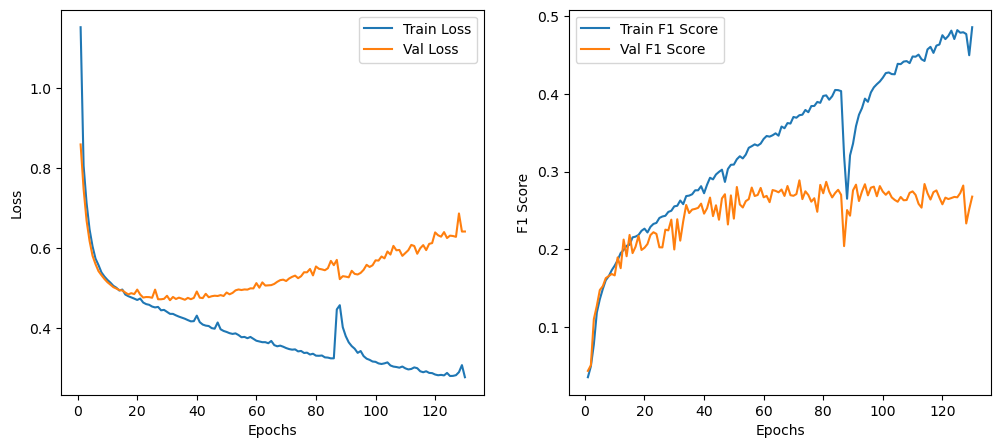

In [14]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()